In [1]:
# import computationally expensive model from file (computed in cell above)
from scipy.sparse import *
import numpy as np
import pickle
import random
xs = pickle.load(open('scratch/embeddings.pkl', 'rb'))
vocab = pickle.load(open('scratch/vocab.pkl', 'rb'))
vocab_inv = {vocab[w]:w for w in vocab}

In [ ]:
# TEST: find similar word from randomly picked one
from scipy import spatial
from operator import itemgetter

start_word = 'awesome'
if not start_word or (start_word not in vocab):
    # if no start word is chosen, eg. start_word = None, pick one at random
    start_word = vocab_inv[np.random.randint(0, xs.shape[0])]
    print('starting from random word:', start_word)
else:
    print('starting from word:', start_word)

start_ind = vocab.get(start_word)
start_vec = xs[start_ind]

# calculate distance to every other word and print out the nearest 10:
distances = [(i, spatial.distance.cosine(start_vec, xs[i])) for i in range(xs.shape[0])]
distances_sorted = sorted(distances,key=itemgetter(1))
print('Order Distance Word')
print('-------------------')
for k in range(10):
    print('{:<6d}{:<9.5f}{:s}'.format(k, distances_sorted[k][1], vocab_inv[distances_sorted[k][0]]))

In [2]:
# build feature vectors for every tweed in the full corpus set
training_tweeds = []

print('Assigning feature vector to tweeds for training...')
counter = 1
for label, fn in zip([1, -1], ['datasets/train_pos.txt', 'datasets/train_neg.txt']):
    with open(fn) as f:
        for line in f:
            tokens = [vocab.get(t, -1) for t in line.strip().split()]
            tokens = [t for t in tokens if t >= 0]
            if not tokens:
                print("  couldn't assign tweed '{}' a feature.".format(line[:-2]))
                continue
            vectors = np.array([xs[t] for t in tokens])
            avg_vector = np.average(vectors, axis=0)
            training_tweeds.append((label,avg_vector))
            
            if counter % 50000 == 0:
                print("processed {} tweeds (working on set '{}')".format(counter, fn))
            counter += 1
print("Finished processing {} tweeds.".format(counter, fn))

Assigning feature vector to tweeds for training...
  couldn't assign tweed 'heyheyheyhe' a feature.
processed 50000 tweeds (working on set 'datasets/train_pos.txt')
  couldn't assign tweed 'gilipollas #everywher' a feature.
  couldn't assign tweed '#absolutely beastingi' a feature.
processed 100000 tweeds (working on set 'datasets/train_neg.txt')
  couldn't assign tweed '#killingmesoftl' a feature.
  couldn't assign tweed 'catss everywhere' a feature.
processed 150000 tweeds (working on set 'datasets/train_neg.txt')
Finished processing 199996 tweeds.


In [ ]:
# TEST: Display 10 random words in a 2D PCA representation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

pca = True
words = None

if not words:
    n = 10
    wordindices = np.random.randint(0, xs.shape[0], size = n)
    vectors = [xs[i] for i in wordindices]
    words = [vocab_inv[i] for i in wordindices]
else:
    words = [w for w in words if w in vocab]
    n = len(words)
    wordindices = [vocab[w] for w in words]
    vectors = [xs[i] for i in wordindices]

pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
# with t-SNE:
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)

plt.figure(figsize=(5,5))
plt.axis([-3, 3, -3, 3])
    
for point, word in zip(vectors2d , words):
    # plot points
    plt.scatter(point[0], point[1], c='r')
    # plot word annotations
    plt.annotate(word, xy = (point[0], point[1]), xytext = (-4, -0),
                 textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.title('2D representation')
plt.show()

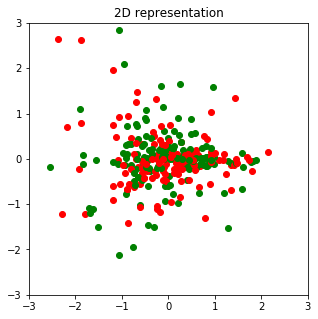

In [30]:
# TEST: Display 40 random tweeds colored with their label in a 2D PCA representation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

n = 300
tweetindices = np.random.randint(0, len(training_tweeds), size = n)
labels = [training_tweeds[i][0] for i in tweetindices]
vectors = [training_tweeds[i][1] for i in tweetindices]

pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
# with t-SNE:
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)

plt.figure(figsize=(5,5))
plt.axis([-3, 3, -3, 3])
    
for point, label in zip(vectors2d , labels):
    # plot points
    plt.scatter(point[0], point[1], c=('r' if label==-1 else 'g'))
plt.title('2D representation')
plt.show()